## WISE YSO variability analysis tutorial
by Wooseok Park  
ref: https://ui.adsabs.harvard.edu/abs/2021ApJ...920..132P/abstract

WISE 관측 데이터를 이용한 원시성의 밝기변화 시계열 데이터 분석 프로젝트 튜토리얼입니다.  
데이터의 정제 과정 그리고 각 별들의 밝기변화 데이터에서 통계적 정보를 추출하는 과정을 설명하였습니다.  
추후 더욱 짜임새 있게 업데이트 예정입니다.

In [2]:
import numpy as np
import pandas as pd
from astropy import table as aptable
from astropy.io import votable as apvot
import pyvo
import matplotlib 
import matplotlib.pyplot as plt

In [21]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

# define and use original round rather than using python round
def my_round(in_number, ndigits=0, rounding_rule=1):
    """rounding_rule==1: ROUND_HALF_UP, Round to nearest, ties away from zero
       rounding_rule==2: ROUND_HALF_EVEN, Round to nearest, ties to even """
    # make float expression
    if ndigits > 0:
        expression = '0.' + '0' * ndigits
        number = in_number
    else:  # 0 or negative
        expression = '0'
        number = in_number / (10 ** (-ndigits))

    # round by rounding rule
    if rounding_rule == 2:
        round_number = Decimal(number).quantize(Decimal(expression), rounding=ROUND_HALF_EVEN)
    else:
        round_number = Decimal(number).quantize(Decimal(expression), rounding=ROUND_HALF_UP)

    # return number
    if ndigits > 0:
        return float(round_number)
    else:  # 0 or negative
        return int(round_number * (10 ** (-ndigits)))

In [3]:
ysos = pd.read_csv('wise_csv/ref_catalogue.csv')
ysos

,index,ra,dec,class,cat
0,1,85.677833,-10.419250,P,Megeath
1,2,85.627292,-10.179944,D,Megeath
2,3,85.756625,-10.130639,D,Megeath
3,4,85.554458,-10.093028,P,Megeath
4,5,85.632375,-10.090611,D,Megeath
...,...,...,...,...,...
6984,10515,77.331876,28.925760,III,Esplin&Luhman
6985,10516,77.368540,29.049981,III,Esplin&Luhman
6986,10517,77.496197,30.612497,NaN,Esplin&Luhman
6987,10518,77.499075,30.611616,III,Esplin&Luhman


In [4]:
myaptable = aptable.Table(
    np.transpose([ysos.ra.values, ysos.dec.values]),
    names=['RA','DEC']
)

# print(myaptable)

myvotablefile = apvot.from_table(myaptable)
for r in myvotablefile.resources:
    mytable = r
    for t in r.tables:
        print(t)

     RA          DEC     
------------ ------------
85.677833333    -10.41925
85.627291666 -10.17994444
   85.756625 -10.13063888
85.554458333 -10.09302777
   85.632375 -10.09061111
85.658458333 -10.06211111
85.749708333 -10.06111111
85.749958333 -10.05983333
      85.741 -10.05980555
85.654583333 -10.05822222
         ...          ...
    76.97904    25.004258
   77.026518    30.439701
   77.029593    24.453346
   77.034035    24.454043
   77.034154    24.454281
   77.177249     30.44912
   77.331876     28.92576
    77.36854    29.049981
   77.496197    30.612497
   77.499075    30.611616
   78.114949    22.896918
Length = 6989 rows


In [5]:
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
result = service.run_async("""
           SELECT mjd, w1mag, w1sigm, w2mag, w2sigm, qual_frame, ra, dec
           FROM neowiser_p1bs_psd
           WHERE CONTAINS(POINT('ICRS',ra, dec), CIRCLE('ICRS',85.677833333, -10.41925,3/3600))=1
    """)
tab = result.to_table().to_pandas()
tab

,mjd,w1mag,w1sigm,w2mag,w2sigm,qual_frame,ra,dec
0,58748.234578,7.955,0.007,6.928,0.007,10,85.677900,-10.419332
1,59265.224327,8.507,0.009,7.254,0.010,10,85.677833,-10.419346
2,59265.289651,8.286,0.008,7.255,0.007,10,85.677857,-10.419367
3,59265.158875,8.295,0.008,7.263,0.009,10,85.677876,-10.419378
4,59265.355103,8.389,0.009,7.211,0.008,10,85.677855,-10.419368
...,...,...,...,...,...,...,...,...
236,58015.415546,8.809,0.008,7.470,0.010,10,85.677872,-10.419287
237,58015.284643,8.844,0.008,7.563,0.008,10,85.677881,-10.419312
238,58169.333273,8.911,0.008,7.747,0.008,10,85.677875,-10.419346
239,58169.202369,8.879,0.008,7.679,0.007,10,85.677899,-10.419338


In [6]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(1, 2, column_widths=[0.65, 0.35],
                    horizontal_spacing=0.17)

fig.add_trace(
    go.Scatter(x=tab.mjd, y=tab.w2mag, mode='markers', name='W2 magnitude'),
    row=1, col=1, 
    
)
fig.update_yaxes(autorange="reversed", row=1, col=1)
fig.add_trace(
    go.Scatter(x=tab.ra, y=tab.dec, mode='markers', name='data position'),
    row=1, col=2
)

fig.update_layout(template='plotly_white',
                xaxis1_title='Julian Date [Days]', 
                yaxis2_title='Declination',
                xaxis2_title='Right Ascension',
                margin_autoexpand=True
            )

fig.show()


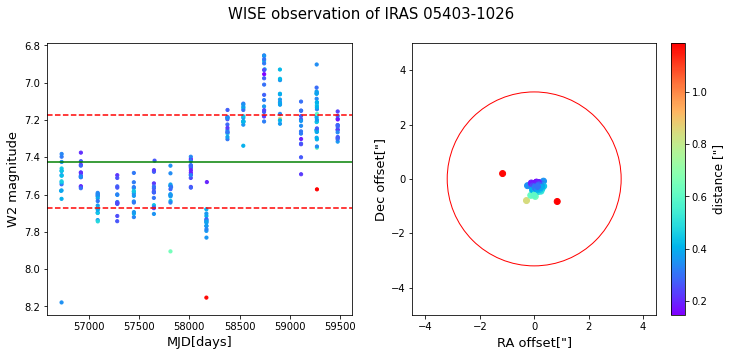

In [7]:
RA = 85.677833333
DEC = -10.41925
dist = np.sqrt(
    (tab.ra - RA)**2 + (tab.dec - DEC)**2
  )*3600  #distance from catalogue position


# W2 lightcurve

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(tab.mjd,tab.w2mag,c=dist, cmap='rainbow', s=10)
ax[0].invert_yaxis()
ax[0].set_xlabel('MJD[days]',size=13)
ax[0].set_ylabel('W2 magnitude',size=13)

# plot mean, std of brightness
ax[0].axhline(tab.w2mag.median(), color='g')
ax[0].axhline(tab.w2mag.median() + tab.w2mag.std(), color='r', linestyle='--')
ax[0].axhline(tab.w2mag.median() - tab.w2mag.std(), color='r', linestyle='--')

# W2 datapoint ra/dec distance plot
dist_plot = ax[1].scatter((tab.ra-RA)*3600, (tab.dec-DEC)*3600, c=dist, cmap='rainbow')

circ1 = plt.Circle((0,0), 
                  6.4/2, # WISE W2 angular resolution : 6.4 arcsec. Deg = arcsec/3600 ≈ arcsec*0.0002778
                  color='r',
                  fill=False)
cbar2 = plt.colorbar(dist_plot)#,cax=axc1)
cbar2.ax.set_ylabel('distance ["]',size=12)
ax[1].axis('equal')
ax[1].add_artist(circ1)
ax[1].set_xlim(-5, 5) 
ax[1].set_ylim(-5, 5)
# ax.invert_xaxis()
# ax.ticklabel_format(useOffset=False)
ax[1].set_xlabel('RA offset["]',size=13)
ax[1].set_ylabel('Dec offset["]',size=13)
# dist_std = np.std(np.sqrt(radist**2+decdist**2)*3600)
# print(f'STD distance from center is : {dist_std:.3f}"')

plt.suptitle('WISE observation of IRAS 05403-1026', size=15)
plt.show()

이렇게 원시성 IRAS 05403-1026의 WISE 밝기 데이터를 query로 가져와 시간에 따른 밝기변화(왼쪽) 및 공간상 관측된 위치(오른쪽)로 나타내었습니다.  
녹색 실선은 밝기의 중앙값, 빨간 점선은 중앙값으로부터 $\pm$ 1sigma (표준편차)를 나타냅니다. 각 점의 색은 기준 좌표로부터의 거리를 나타냅니다. 오른쪽 동그라미는 기준 좌표로부터 탐색된 반지름 3"의 범위를 나타냅니다. 기준좌표에서 반지름 3" 내로 검색을 수행했기 때문에, 밝기 데이터는 모두 동그라미 내에 위치하고 있습니다.

#### 수집한 RAW 데이터에서는 여러 **문제**가 보여지고 있습니다.  

1. 밝기의 중앙값인 녹색 선과 1sigma 범위인 빨간 점선을 고려하였을때 이를 벗어나는 개별 datapoint가 매우 많습니다.
2. 이 중에는 왼쪽 plot에서 다른 관측치들과 비교해 매우 떨어져 있어 오류로 보여지는 outlier 데이터가 있고, 그 중에는 빨간 점과 같이 다른 datapoint에 비해 많이 떨어져 있는 공간적 outlier (다른 원시성,혹은 근처 타 천체로 인한 light pollution일 가능성 있음)가 존재합니다.
3. 180일 (6개월) 마다 관측을 하다보니 6개월에 한번씩 20포인트가 수 시간~수 일에 걸쳐 몰려 있는 아주 특이한 time grid를 가지고 있으며, 이 때문에 fitting 및 feature 계산을 어렵게 합니다. 
4. 개별 datapoint가 한 관측(6개월마다) 때 측정값들이 꽤 퍼져 있습니다. 원시성이 수 시간~수 일에 걸쳐 중적외선 밝기가 빠르게 변화하는 것은 매우 드물기 때문에 datapoint 하나하나를 완전히 신뢰할 수 없습니다.

#### 이러한 문제들을 해결하기 위해 데이터를 다음과 같이 가공하였습니다.
1. 공간상의 outlier을 제거하기 위해 기준점으로부터 각 datapoint까지 거리의 평균, 표준편차($\sigma$)를 구하고  
평균으로부터 거리 $2\sigma$ 이하의 datapoint만 사용합니다.


Text(0.5, 1.0, 'Lightcurve - spatial outliers removed')

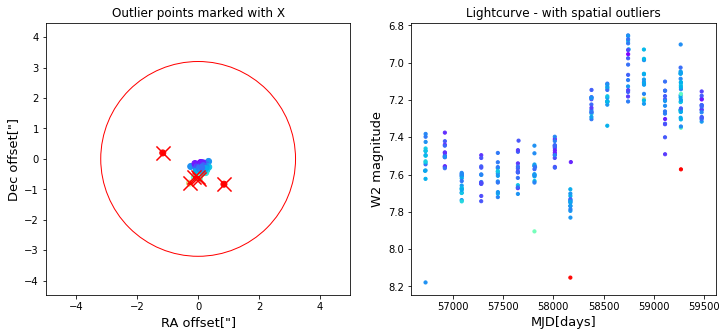

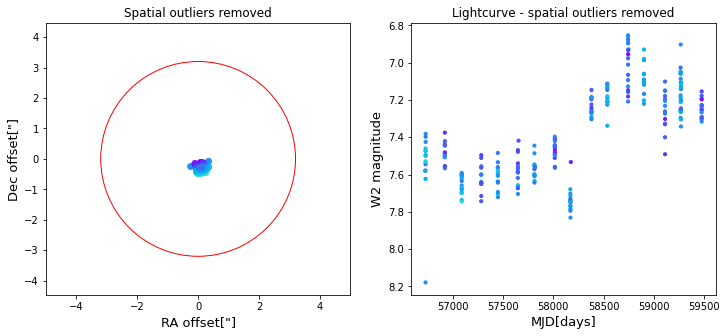

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

# plot outliers
outliers = tab.loc[dist[(dist < dist.mean() - 2*dist.std()) |\
     (dist > dist.mean() + 2*dist.std())].index
     ]

circ2 = plt.Circle((0,0), 
                  6.4/2, # WISE W2 angular resolution : 6.4 arcsec. Deg = arcsec/3600 ≈ arcsec*0.0002778
                  color='r',
                  fill=False, )
ax[0].scatter((tab.ra-RA)*3600, (tab.dec-DEC)*3600, c=dist, cmap='rainbow')
ax[0].scatter((outliers.ra-RA)*3600, (outliers.dec-DEC)*3600, marker='x', c='r', s=200)
ax[0].axis('equal')
ax[0].set_xlim(-5, 5) 
ax[0].set_ylim(-5, 5)
ax[0].add_artist(circ2)

ax[0].set_title('Outlier points marked with X')
ax[0].set_xlabel('RA offset["]',size=13)
ax[0].set_ylabel('Dec offset["]',size=13)

ax[1].scatter(tab.mjd, tab.w2mag, 
          c=dist, cmap='rainbow', s=10)
ax[1].invert_yaxis()
ax[1].set_xlabel('MJD[days]',size=13)
ax[1].set_ylabel('W2 magnitude',size=13)
ax[1].set_title('Lightcurve - with spatial outliers')

# lightcurve without spatial outliers
tab_spout = tab.drop(outliers.index, axis=0)

fig2, ax2 = plt.subplots(1, 2, figsize=(12,5))

circ3 = plt.Circle((0,0), 
                  6.4/2, # WISE W2 angular resolution : 6.4 arcsec. Deg = arcsec/3600 ≈ arcsec*0.0002778
                  color='r',
                  fill=False)
s3 = ax2[0].scatter((tab_spout.ra-RA)*3600,(tab_spout.dec-DEC)*3600, c=dist.drop(outliers.index, axis=0), cmap='rainbow')
s3.set_clim([dist.min(), dist.max()])
ax2[0].axis('equal')
ax2[0].set_xlim(-5, 5) 
ax2[0].set_ylim(-5, 5)
ax2[0].add_artist(circ3)
ax2[0].set_title('Spatial outliers removed')
ax2[0].set_xlabel('RA offset["]',size=13)
ax2[0].set_ylabel('Dec offset["]',size=13)

s2 = ax2[1].scatter(tab_spout.mjd, tab_spout.w2mag, 
          c=dist.drop(outliers.index, axis=0),
          cmap='rainbow', s=10)
s2.set_clim([dist.min(), dist.max()])
ax2[1].invert_yaxis()
ax2[1].set_xlabel('MJD[days]',size=13)
ax2[1].set_ylabel('W2 magnitude',size=13)
ax2[1].set_title('Lightcurve - spatial outliers removed')

위와 같이 공간상의 outlier을 제거했을때 밝기 변화 lightcurve에서의 outlier도 일부 제거됨을 확인할 수 있습니다.


2. 6개월마다 관측한 datapoint들 (<U>특정 시점에 모여 있는 점들</U>)을 한 그룹으로 묶고 해당 그룹에서 $1\sigma$ 이상 밝기 차이를 보이는 datapoint를 outlier로 간주, 제거합니다. 한 그룹의 datapoint들은 밝기변화가 정규분포를 따른다고 가정했을 때 밝기변화 범위 중 16%-84% 를 $1\sigma$ 범위로 설정할 수 있습니다.   

3. time grid를 균일하게 하기 위해 2.에서 outlier 제거한 그룹 당 밝기 값을 모두 평균하여 한 datapoint로 만들고 그룹 내 밝기변화 표준편차를 datapoint 오차로 지정합니다. 



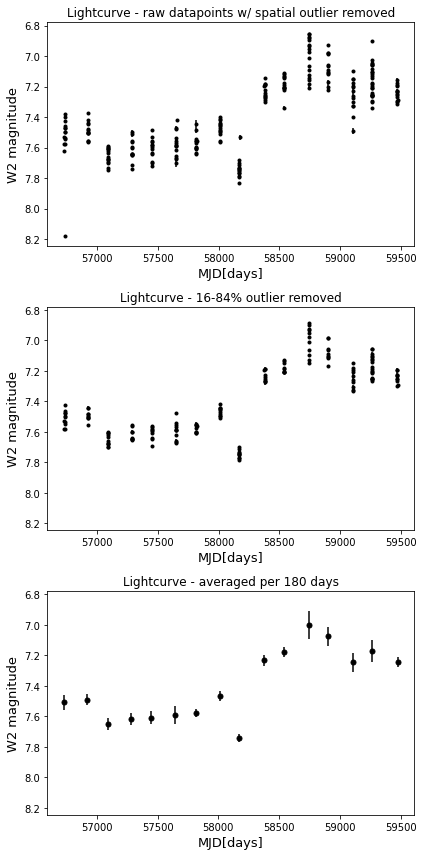

In [61]:
# datapoint를 +- 100일 범위로 그룹화하기
tab_group = tab_spout.copy().sort_values('mjd').reset_index(drop=True) # 날짜 순으로 정렬
tab_group['group'] = 0 # 그룹 데이터 생성
jd = tab_group['mjd']
gnum = 1
group_first_date = tab_group['mjd'][0]
for i in tab_group.index[:-1]:
    if jd[i] + 100 < jd[i+1]: # 다음 관측일이 100일보다 이후일 때 - 앞 데이터들에 그룹 숫자 부여
        tab_group.loc[(jd >= group_first_date) & (jd < jd[i+1]), 'group'] = gnum
        group_first_date = jd[i+1]
        gnum += 1
    # 마지막 그룹에 숫자 부여
    tab_group.loc[jd >= group_first_date, 'group'] = gnum


# 16%-84% 범위 벗어나는 outlier 제거 및 그룹 별 한 datapoint로 average
gr_list = []
gr_avg_list = []
for i in tab_group['group'].unique():
    # outlier removed data
    gr = tab_group.loc[tab_group['group'] == i]
    gr = gr.sort_values('w2mag').reset_index(drop=True)
    gr = gr.iloc[my_round(len(gr)*0.16) : my_round(len(gr)*0.84)] # choose only 16%-84% magnitude
    gr_list.append(gr)

    # averaged per one group
    gr_avg = pd.Series({'mjd':gr['mjd'].mean(), 'w2mag':gr['w2mag'].mean(),
                        'w2sigm':np.sqrt(gr['w2sigm'].mean()**2 + gr['w2mag'].std()**2)})
    gr_avg_list.append(gr_avg)

df_cut = pd.concat(gr_list).sort_values('mjd').reset_index(drop=True) # outlier removed 
df_avg = pd.concat(gr_avg_list,axis=1).T # outlier removed + averaged per one group


# lightcurve, outlier removed, averaged plot - total 3 plots
fig, ax = plt.subplots(3,1,figsize=(6,12), sharey=True)

ax[0].errorbar(tab_group['mjd'], tab_group['w2mag'], tab_group['w2sigm'], fmt='k.')
ax[1].errorbar(df_cut['mjd'], df_cut['w2mag'], df_cut['w2sigm'], fmt='k.')
ax[2].errorbar(df_avg['mjd'], df_avg['w2mag'], df_avg['w2sigm'], fmt='k.',ms=10)

for i in range(len(ax)):
    ax[i].invert_yaxis()
    ax[i].set_xlabel('MJD[days]',size=13)
    ax[i].set_ylabel('W2 magnitude',size=13)

ax[0].set_title('Lightcurve - raw datapoints w/ spatial outlier removed')
ax[1].set_title('Lightcurve - 16-84% outlier removed')
ax[2].set_title('Lightcurve - averaged per 180 days')

plt.tight_layout()
plt.show()

이와 같이, outlier 제거 및 관측 시기 별 평균화를 통해 raw data로부터 신빙성 있는 오차 범위를 가진 data를 생성하였습니다 (상단의 마지막 그래프 참조)

### Contents
1. Raw data 로 ra/dec plot 및 lightcurve plot
2. Outlier removing / averaging
3. Make statistic information from each lightcurve 
4. Color variation 

In [1]:
import numpy as np
import pandas as pa
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sea
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.timeseries import LombScargle
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit

In [2]:
plt.style.use('seaborn-colorblind')

### 1. Raw data ra/dec plot & lightcurve plot

In [3]:
# 데이터로 distance 자르기   - raw 데이터 하나 이용

raw = pd.read_csv('/home/wooseok/WISE_data/edisk/edisk_irsa_catalog_search_results_tbl.csv')
raw.head()

,cntr_01,dist_x,pang_x,ra_u_01,dec_u_01,ra_01,dec_01,ra,dec,sigra,...,w3sigmpro_allwise,w4mpro_allwise,w4sigmpro_allwise,tmass_key,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass
0,1,2.339082,91.552032,04:04:42.85,26:18:56.3,61.178542,26.315639,61.179266,26.315621,0.0269,...,0.011,-0.031,0.016,837132379.0,14.129,NaN,11.908,NaN,9.859,0.043
1,1,2.548847,93.943975,04:04:42.85,26:18:56.3,61.178542,26.315639,61.179330,26.315590,0.0274,...,0.011,-0.031,0.016,837132379.0,14.129,NaN,11.908,NaN,9.859,0.043
2,1,2.571273,91.347626,04:04:42.85,26:18:56.3,61.178542,26.315639,61.179338,26.315622,0.0283,...,0.011,-0.031,0.016,837132379.0,14.129,NaN,11.908,NaN,9.859,0.043
3,1,2.601738,99.501374,04:04:42.85,26:18:56.3,61.178542,26.315639,61.179337,26.315520,0.0288,...,0.011,-0.031,0.016,837132379.0,14.129,NaN,11.908,NaN,9.859,0.043
4,1,2.606952,85.421754,04:04:42.85,26:18:56.3,61.178542,26.315639,61.179347,26.315697,0.0301,...,0.011,-0.031,0.016,837132379.0,14.129,NaN,11.908,NaN,9.859,0.043


In [4]:
raw1 = raw.loc[:,['cntr_01', 'dist_x','ra','dec',
                  'w1mpro', 'w1sigmpro','w2mpro', 'w2sigmpro','qual_frame','mjd']]

'''
dist_x : 설정한 기준 ra dec (카탈로그 정보) 에서의 거리 arcsecond
ra : WISE 데이터의 ra (in decimal)
dec : WISE 데이터의 dec (in decimal)
w1mpro, w2mpro : WISE W1, W2 magnitude 
w1sigmpro, w2sigmpro : WISE W1, W2 magnitude error
qual_frame : 이미지 퀄리티 (0 인 데이터는 제거해야 함)
mjd : MJD
'''

raw1

,cntr_01,dist_x,ra,dec,w1mpro,w1sigmpro,w2mpro,w2sigmpro,qual_frame,mjd
0,1,2.339082,61.179266,26.315621,7.936,0.015,5.207,0.018,10,57992.690954
1,1,2.548847,61.179330,26.315590,8.263,0.016,5.184,0.013,10,58515.310369
2,1,2.571273,61.179338,26.315622,8.042,0.016,5.494,0.012,10,58357.118660
3,1,2.601738,61.179337,26.315520,8.123,0.014,5.209,0.020,10,57794.269119
4,1,2.606952,61.179347,26.315697,8.095,0.016,5.285,0.017,10,57628.579232
...,...,...,...,...,...,...,...,...,...,...
3792,22,0.715759,290.112788,11.336341,10.973,0.022,8.632,0.014,10,56945.035357
3793,22,0.719099,290.112800,11.336349,10.963,0.024,8.771,0.015,5,58751.080067
3794,22,0.726292,290.112797,11.336344,10.999,0.023,8.612,0.014,10,56944.903817
3795,22,0.726800,290.112787,11.336336,11.077,0.027,8.772,0.015,5,58026.315679


STD distance from center is : 1.007"


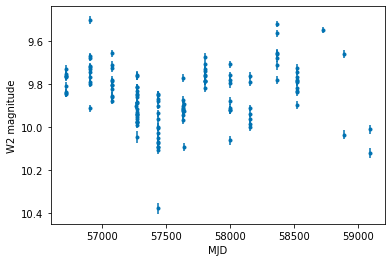

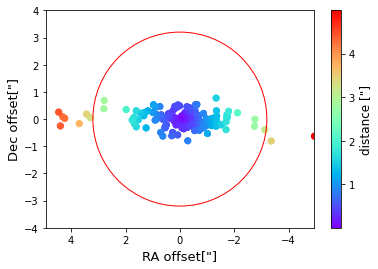

In [7]:
c1 = raw1[raw1.cntr_01 == 15]


# W2 lightcurve

fig0, ax0 = plt.subplots()
ax0.errorbar(c1.mjd,c1.w2mpro,c1.w2sigmpro,fmt='.')
ax0.invert_yaxis()
ax0.set_xlabel('MJD')
ax0.set_ylabel('W2 magnitude')


# W2 datapoint ra/dec distance plot

ra2 = c1.ra
dec2 = c1.dec
dist2 = c1.dist_x #distance from catalogue position

radist = abs(ra2-np.mean(ra2)) #distance from mean position
decdist = abs(dec2-np.mean(dec2))

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter((ra2-np.mean(ra2))*3600, (dec2-np.mean(dec2))*3600,c=np.sqrt(radist**2+decdist**2)*3600,
                    cmap='rainbow')

circ1 = plt.Circle((0,0), 
                  6.4/2, # WISE W2 angular resolution : 6.4 arcsec. Deg = arcsec/3600 ≈ arcsec*0.0002778
                  color='r',
                  fill=False)
cbar2 = plt.colorbar(ax.scatter((ra2-np.mean(ra2))*3600, (dec2-np.mean(dec2))*3600,c=np.sqrt(radist**2+decdist**2)*3600,
            cmap='rainbow'))#,cax=axc1)
cbar2.ax.set_ylabel('distance ["]',size=12)
ax.axis('equal')
ax.add_artist(circ1)
ax.set_xlim(-4, 4) 
ax.set_ylim(-4, 4)
ax.invert_xaxis()
ax.ticklabel_format(useOffset=False)
ax.set_xlabel('RA offset["]',size=13)
ax.set_ylabel('Dec offset["]',size=13)
dist_std = np.std(np.sqrt(radist**2+decdist**2)*3600)
print(f'STD distance from center is : {dist_std:.3f}"')

In [ ]:
# point distance 의 여러 경우를 보여주기
# dist_sd 계산하고 dist_sd < 0.3" 을 이용함

### 2. Outlier 제거, Averaging

1. Load a YSO raw photometric data (~100 datapoints per source)
2. Divide raw data by a difference within 100 days -> about 14 epochs (batches)
3. In each epoch, remove outliers, which are <=16th percentile and >=84th percentile in brightness (1 sigma)
4. Average raw data into a datapoint with an error each epoch 
5. Concatenate divided epoch into one table / separately save outlier removed data (* _alld.csv, ~100 points per source) and outlier removed+averaged data (* _cavg.csv, ~14 points per source) 

***WISE raw data is currently provided from Carlos Contreras Peña**

In [12]:
# to check source numbers causing error 
err_index = []

for index in range(1,10520):
    try:
        if index < 10000:   #megeath, dunham 
            wavg = pa.read_csv('/home/wooseok/WISE_data/3rdnewwise/yso_data/YSOwise_lc_' + str(index) + '_dcut.dat',
                               sep="\s+", header=None, skiprows=1,
                               names=['mjd', 'mag', 'emag', 'flt', 'flag', 'dist', 'ra', 'dec'])
            source = pa.read_csv('/home/wooseok/WISE_data/csvfiles/ysos_c.csv')
            ev_stage = source.loc[source['index'] == index,'class'].values

        else:  #taurus
            wavg = pa.read_csv('/home/wooseok/WISE_data/3rdnewwise/yso_data/YSOwise_lc_' + str(index) + '_dcut.dat',
                           sep="\s+", header=None, skiprows=1,
                           names=['mjd', 'mag', 'emag', 'flt', 'flag', 'dist', 'ra', 'dec'])
            source = pa.read_csv('/home/wooseok/WISE_data/Taurus/ysos_info.dat',
                    header = None, skiprows=1, sep="\s+",
                     names=['index_1','ra','dec','Disk'])
            ev_stage = source.loc[source['index_1'] == index,'Disk'].values


        # check data existence
        if len(wavg) < 1:
        
            raise ValueError(str(index)+' has no photometric data')


        xw = wavg[(np.isnan(wavg['mag']) == False) & 
                        (np.isnan(wavg['emag']) == False) &
                        (wavg['mjd'] > 56000) &
                        (wavg['flag'] != 0)]

        ## W2 ## 
        xw2 = xw[xw['flt'] == 'W2']
        
        
        # 1. mjd로 줄세우기
        mw2 = xw2.sort_values('mjd').reset_index(drop=True)

        # 2. 100일 간격 넘으면 자르기
        block_list=np.array([])
        j = 0 #처음 j 정의
        for i, d in enumerate(mw2.mjd):

            if i == len(mw2.mjd)-1:

                bw2 = mw2.iloc[j:]

                block_list = np.append(block_list,d)
                globals()['bl{}'.format(len(block_list))] = bw2

            elif abs(d-mw2.mjd[i+1])>100:

                if j == 0 :
                    bw2 = mw2.iloc[:i+1]
                    j = i+1
                else: 
                    bw2 = mw2.iloc[j:i+1]
                    j = i+1

                block_list = np.append(block_list,d) #그냥 bl변수 숫자 기입 위해서      
                globals()['bl{}'.format(len(block_list))] = bw2

        # 3. 16% - 84% cut 하고 새로운 데이터셋 만듬. 한 포인트로 만든 다음 이어붙여서 새로운 소스 데이터를 만들기.
        for i in range(1,len(block_list)+1):
            bl = globals()['bl{}'.format(i)]
            bls = bl.sort_values('mag').reset_index(drop=True)
            bls_cut = bls.iloc[my_round(len(bls)*0.16)-1 : my_round(len(bls)*0.84)]
            globals()['bl{}c'.format(i)] = bls_cut


            #save outlier cut data
            alld = pa.DataFrame()
            alld['mjd'] = bls_cut['mjd']
            alld['mag'] = bls_cut['mag']
            alld['emag'] = bls_cut['emag']
            alld['flt'] = 'W2'
            alld.loc[:,'class'] = ev_stage
            alld['ra'] = bls_cut['ra']
            alld['dec'] = bls_cut['dec']



            globals()['bl{}c_data'.format(i)] = alld


            #one point per block
            new_emag = np.sqrt(np.mean(bls_cut.emag)**2 + np.std(bls_cut.mag)**2)
            new_mag = np.mean(bls_cut.mag)
            new_df = pa.DataFrame()
            new_df['mjd'] = np.array([np.mean(bls_cut['mjd'])])
            new_df['mag'] = np.array([new_mag])
            new_df['emag'] = np.array([new_emag])
            new_df['flt'] = 'W2'
            new_df.loc[:,'class'] = ev_stage
            globals()['bl{}c_avg'.format(i)] = new_df



        ## W1 ## 
        xw1 = xw[xw['flt'] == 'W1']
        
        # 1. mjd로 줄세우기
        mw1 = xw1.sort_values('mjd').reset_index(drop=True)

        # 2. 100일 간격 넘으면 자르기
        block_list1=np.array([])
        j = 0 #처음 j 정의
        for i, d in enumerate(mw1.mjd):

            if i == len(mw1.mjd)-1:

                bw1 = mw1.iloc[j:]

                block_list1 = np.append(block_list1,d)
                globals()['bl{}'.format(len(block_list1))] = bw1

            elif abs(d-mw1.mjd[i+1])>100:

                if j == 0 :
                    bw1 = mw1.iloc[:i+1]
                    j = i+1
                else: 
                    bw1 = mw1.iloc[j:i+1]
                    j = i+1

                block_list1 = np.append(block_list1,d) #그냥 bl변수 숫자 기입 위해서      
                globals()['bl{}'.format(len(block_list1))] = bw1
                
        # 3. 16% - 84% cut 하고 새로운 데이터셋 만듬. 한 포인트로 만든 다음 이어붙여서 새로운 소스 데이터를 만들기.
        for i in range(1,len(block_list1)+1):
            bl = globals()['bl{}'.format(i)]
            bls = bl.sort_values('mag').reset_index(drop=True)
            bls_cut = bls.iloc[my_round(len(bls)*0.16)-1 : my_round(len(bls)*0.84)]  # 인덱싱할때는 iloc 으로 해야 일관성있다. loc로 하면 파이썬 인덱싱과 다르게 첫값, 끝값이 모두 포함됨.
            globals()['bl{}c'.format(i)] = bls_cut
            
            #save outlier cut data
            alld = pa.DataFrame()
            alld['mjd'] = bls_cut['mjd']
            alld['mag'] = bls_cut['mag']
            alld['emag'] = bls_cut['emag']
            alld['flt'] = 'W1'
            alld.loc[:,'class'] = ev_stage
            alld['ra'] = bls_cut['ra']
            alld['dec'] = bls_cut['dec']
            globals()['bl{}c_w1_data'.format(i)] = alld
            
            #one point per block
            new_emag = np.sqrt(np.mean(bls_cut.emag)**2 + np.std(bls_cut.mag)**2)
            new_mag = np.mean(bls_cut.mag)
            new_df = pa.DataFrame()
            new_df['mjd'] = np.array([np.mean(bls_cut['mjd'])])
            new_df['mag'] = np.array([new_mag])
            new_df['emag'] = np.array([new_emag])
            new_df['flt'] = 'W1'
            new_df.loc[:,'class'] = ev_stage
            globals()['bl{}c_w1_avg'.format(i)] = new_df
            
        
        
        


        #save averaged data
        bl_avg = pa.DataFrame()
        for i in range(1,len(block_list1)+1):
            bl_avg = bl_avg.append(globals()['bl{}c_w1_avg'.format(i)])

        for i in range(1,len(block_list)+1):
            bl_avg = bl_avg.append(globals()['bl{}c_avg'.format(i)])



        bl_avg = bl_avg.reset_index(drop=True)                            
        bl_avg.to_csv('/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data_new/'+str(index)+'_cavg.csv',index=None)



        #save all datapoints without outliers
        bl_data = pa.DataFrame()
        for i in range(1,len(block_list1)+1):
            bl_data = bl_data.append(globals()['bl{}c_w1_data'.format(i)])
        for i in range(1,len(block_list)+1):
            bl_data = bl_data.append(globals()['bl{}c_data'.format(i)])
#         for i in range(1,len(block_list)+1):
#             bl_data = bl_data.append(globals()['bl{}c_color'.format(i)])

        bl_data = bl_data.reset_index(drop=True)
        bl_data.to_csv('/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data_new/'+str(index)+'_alld.csv',index=None)


        print(str(index)+' complete')

    except Exception as e:
        print(str(index)+'  error found:', e)
        if len(wavg) >= 1:
            err_index.append(index)
print('Index with error: ',err_index)        

1  error found: name 'my_round' is not defined
2  error found: name 'my_round' is not defined
3  error found: name 'my_round' is not defined
4  error found: name 'my_round' is not defined
5  error found: name 'my_round' is not defined
6  error found: name 'my_round' is not defined
7  error found: name 'my_round' is not defined
8  error found: 8 has no photometric data
9  error found: name 'my_round' is not defined
10  error found: name 'my_round' is not defined
11  error found: name 'my_round' is not defined
12  error found: name 'my_round' is not defined
13  error found: name 'my_round' is not defined
14  error found: name 'my_round' is not defined
15  error found: name 'my_round' is not defined
16  error found: 16 has no photometric data
17  error found: name 'my_round' is not defined
18  error found: name 'my_round' is not defined
19  error found: name 'my_round' is not defined
20  error found: name 'my_round' is not defined
21  error found: 21 has no photometric data
22  error foun

181  error found: name 'my_round' is not defined
182  error found: name 'my_round' is not defined
183  error found: name 'my_round' is not defined
184  error found: name 'my_round' is not defined
185  error found: name 'my_round' is not defined
186  error found: name 'my_round' is not defined
187  error found: name 'my_round' is not defined
188  error found: name 'my_round' is not defined
189  error found: name 'my_round' is not defined
190  error found: name 'my_round' is not defined
191  error found: name 'my_round' is not defined
192  error found: name 'my_round' is not defined
193  error found: name 'my_round' is not defined
194  error found: name 'my_round' is not defined
195  error found: name 'my_round' is not defined
196  error found: 196 has no photometric data
197  error found: name 'my_round' is not defined
198  error found: name 'my_round' is not defined
199  error found: name 'my_round' is not defined
200  error found: name 'my_round' is not defined
201  error found: name 

368  error found: name 'my_round' is not defined
369  error found: name 'my_round' is not defined
370  error found: name 'my_round' is not defined
371  error found: name 'my_round' is not defined
372  error found: name 'my_round' is not defined
373  error found: name 'my_round' is not defined
374  error found: name 'my_round' is not defined
375  error found: name 'my_round' is not defined
376  error found: name 'my_round' is not defined
377  error found: name 'my_round' is not defined
378  error found: name 'my_round' is not defined
379  error found: 379 has no photometric data
380  error found: name 'my_round' is not defined
381  error found: name 'my_round' is not defined
382  error found: name 'my_round' is not defined
383  error found: name 'my_round' is not defined
384  error found: name 'my_round' is not defined
385  error found: name 'my_round' is not defined
386  error found: name 'my_round' is not defined
387  error found: name 'my_round' is not defined
388  error found: name 

539  error found: name 'my_round' is not defined
540  error found: name 'my_round' is not defined
541  error found: name 'my_round' is not defined
542  error found: name 'my_round' is not defined
543  error found: name 'my_round' is not defined
544  error found: name 'my_round' is not defined
545  error found: name 'my_round' is not defined
546  error found: name 'my_round' is not defined
547  error found: name 'my_round' is not defined
548  error found: name 'my_round' is not defined
549  error found: name 'my_round' is not defined
550  error found: name 'my_round' is not defined
551  error found: name 'my_round' is not defined
552  error found: name 'my_round' is not defined
553  error found: name 'my_round' is not defined
554  error found: name 'my_round' is not defined
555  error found: name 'my_round' is not defined
556  error found: name 'my_round' is not defined
557  error found: name 'my_round' is not defined
558  error found: name 'my_round' is not defined
559  error found: na

720  error found: name 'my_round' is not defined
721  error found: name 'my_round' is not defined
722  error found: name 'my_round' is not defined
723  error found: name 'my_round' is not defined
724  error found: name 'my_round' is not defined
725  error found: name 'my_round' is not defined
726  error found: name 'my_round' is not defined
727  error found: name 'my_round' is not defined
728  error found: name 'my_round' is not defined
729  error found: name 'my_round' is not defined
730  error found: name 'my_round' is not defined
731  error found: name 'my_round' is not defined
732  error found: name 'my_round' is not defined
733  error found: [Errno 2] No such file or directory: '/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data_new/733_cavg.csv'
734  error found: name 'my_round' is not defined
735  error found: name 'my_round' is not defined
736  error found: name 'my_round' is not defined
737  error found: name 'my_round' is not defined
738  error found: name 'my_round' is not 

KeyboardInterrupt: 

### A lightcurve example of result
Raw data에서 1 sigma 이상의 outlier을 제거하고 6개월마다 평균을 내어 밝기변화 분석에 용이한 형태로 가공함

**Raw data**

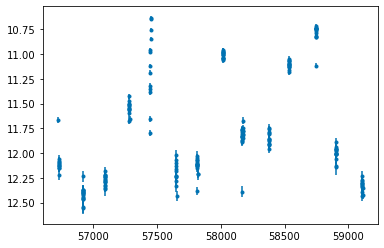

In [13]:
index = 77
yso0 = pa.read_csv('/home/wooseok/WISE_data/3rdnewwise/yso_data/YSOwise_lc_' + str(index) + '_dcut.dat',
                               sep="\s+", header=None, skiprows=1,
                               names=['mjd', 'mag', 'emag', 'flt', 'flag', 'dist', 'ra', 'dec'])
yso0 = yso0[(yso0['flt'] == 'W2') &
           (yso0.mjd > 56000)]
plt.errorbar(yso0.mjd,yso0.mag,yso0.emag,fmt='.')
plt.gca().invert_yaxis()

**Outlier removed**

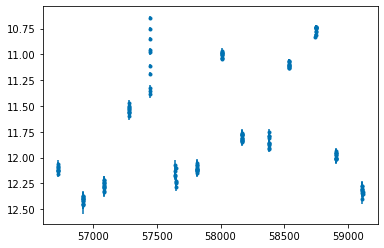

In [14]:
yso1 = pd.read_csv('/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/'+ str(index) +'_alld.csv')

yso1 = yso1[yso1['flt'] == 'W2']
plt.errorbar(yso1.mjd,yso1.mag,yso1.emag,fmt='.')
plt.gca().invert_yaxis()

**Outlier removed + averaged per epoch**

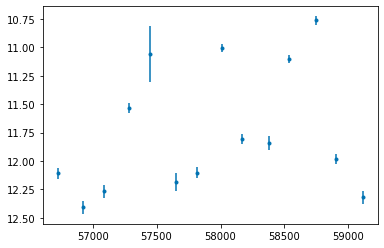

In [15]:
yso2 = pd.read_csv('/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/'+ str(index) +'_cavg.csv')

yso2 = yso2[yso2['flt'] == 'W2']
plt.errorbar(yso2.mjd,yso2.mag,yso2.emag,fmt='.')
plt.gca().invert_yaxis()

### 3. NEOWISE lightcurve statistics 계산, stat table 생성

In [76]:
'''
This is a code extracting statistical information from NEOWISE photometric data
used in WISE YSO variability analysis (Park et al. 2021)
'''


import numpy as np
import pandas as pa
from pandas import DataFrame as df
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
import csv

# import packages to be used in new round function
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

# define and use original round rather than using python round
def my_round(in_number, ndigits=0, rounding_rule=1):
    """rounding_rule==1: ROUND_HALF_UP, Round to nearest, ties away from zero
       rounding_rule==2: ROUND_HALF_EVEN, Round to nearest, ties to even """
    # make float expression
    if ndigits > 0:
        expression = '0.' + '0' * ndigits
        number = in_number
    else:  # 0 or negative
        expression = '0'
        number = in_number / (10 ** (-ndigits))

    # round by rounding rule
    if rounding_rule == 2:
        round_number = Decimal(number).quantize(Decimal(expression), rounding=ROUND_HALF_EVEN)
    else:
        round_number = Decimal(number).quantize(Decimal(expression), rounding=ROUND_HALF_UP)

    # return number
    if ndigits > 0:
        return float(round_number)
    else:  # 0 or negative
        return int(round_number * (10 ** (-ndigits)))

# NEOWISE observation time in Julian Dates
tl1 = 56639
tl2 = 60200

print('start extracting data from WISE.....')

# open csvfile to save all the stats
csvfile = open('test_NEOWISE_YSO_variable_stat.csv', 'w', newline='')
csvdata = csv.writer(csvfile, delimiter=',')
csvdata.writerow(['Index', 'ra', 'dec','dist_sd',
                  'avg_W1', 'stdev_W1', 'avg_eW1',
                  'avg_W2', 'stdev_W2', 'avg_eW2',
                  'N_w1', 'N_w2', 'slope_w1', 'slope_w2',
                  'sd_sdfid_w1_flux', 'sd_sdfid_w2_flux',
                  'sd_sdfid_w1_mag', 'sd_sdfid_w2_mag',
                  'Delta_w1', 'Delta_w2',
                  'Delta_w1_flux', 'Delta_w2_flux',
                  'class', 'catalogue',
                  'Sw1', 'DeltaSw1', 'Sw2', 'DeltaSw2',
                  'SDw1', 'SDfidw1', 'SDw2', 'SDfidw2',
                  'chi2_mean_w1', 'chi2_wmean_w1', 'chi2_slope_w1',
                  'chi2_mean_w2', 'chi2_wmean_w2', 'chi2_slope_w2',
                  'linear_fap_w1', 'linear_fap_w2',
                  'center_mag_w1', 'center_mag_w2',
                  'max_W1', 'min_W1', 'median_W1',
                  'max_W2', 'min_W2', 'median_W2',
                  # Lomb-Scargle Periodogram analysis stats below
                  'period', 'power', 'baluev_fap',
                  'single_fap', 'mod_baluev_fap',
                  'amp', 'sinamp', 'ls_meanjy', 'sd_sdfid_periodrmv', 'sd_periodrmv', 'chi2_period_w2',
                  'linear_fap_periodrmv', 'Deltaw2_periodrmv'
                  ])


source1 = pa.read_csv('/home/wooseok/WISE_data/csvfiles/ysos_c.csv')


source2 = pa.read_csv('/home/wooseok/WISE_data/Taurus/ysos_info.dat',
                                 header=None, skiprows=1, sep="\s+",
                                 names=['index_1', 'ra', 'dec', 'Disk'])

# YSO source informations are from different 3 catalogues. Index < 3505 from Megeath et al. (2012) and >= 3505 from Dunham et al. (2015)
# Index > 10000 from Esplin & Luhman (2019)
for i in range(1,10520):
    try:
        print(i)
        if i < 10000:
            source = source1
            ev_stage = source.loc[source['index'] == i, 'class'].values[0]
            cat = source.loc[source['index'] == i, 'cat'].values[0]
            ra = source.loc[source['index'] == i, 'ra'].values[0]
            dec = source.loc[source['index'] == i, 'dec'].values[0]
        else:
            source = source2
            ev_stage = source.loc[source['index_1'] == i, 'Disk'].values[0]
            cat = 'Esplin&Luhman'
            ra = source.loc[source['index_1'] == i, 'ra'].values[0]
            dec = source.loc[source['index_1'] == i, 'dec'].values[0]

        # call the averaged photometry data
        mddat = pa.read_csv('/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/'
                            + str(i) + '_cavg.csv',
                            names=['mjd', 'mag', 'emag', 'flt', 'class'],
                            skiprows=1)

        xw1 = mddat[mddat['flt'] == 'W1']
        xw2 = mddat[mddat['flt'] == 'W2']

        nw1 = len(xw1)
        nw2 = len(xw2)

        ### *.alld -> outlier removed raw photometry data. Only used for distance STD ###
        mdall = pa.read_csv('/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/'
                            + str(i) + '_alld.csv',
                            names=['mjd', 'mag', 'emag', 'flt', 'class','ra','dec'],
                            skiprows=1)
        mdall2 = mdall[mdall['flt'] == 'W2']

        # distance from mean position
        radist = abs(mdall2.ra - np.mean(mdall2.ra))
        decdist = abs(mdall2.dec - np.mean(mdall2.dec))

        # standard deviation distance of scattered positions
        dist_sd = np.std(np.sqrt(radist ** 2 + decdist ** 2) * 3600)


        #### W2 linear fitting ####

        xw2s = df.sort_values(xw2, 'mjd')
        xw2s = xw2s.reset_index(drop=True)

        if nw2 >= 3:
            w2f = xw2s['mag']
            mjdw2f = xw2s['mjd']
            ew2f = xw2s['emag']

            # magnitude / error to flux / error conversion
            fw2 = 171.85 * 10 ** (-w2f / 2.5)
            ferr2 = ew2f * fw2 / 1.0857


            # comment upper conversion and uncomment below to use magnitude rather than flux
            # fw2 = w2f
            # ferr = ew2f

            # median flux and mean error
            m2f = np.median(fw2)
            em2f = np.mean(ferr2) # just use mean error - it is too complicate to find the value closest to median

            # normalized flux and time
            yfitw2 = (fw2 - m2f) / m2f
            xfitw2 = mjdw2f - mjdw2f[0]




            def func(x, a, b):
                return a * x + b


            # error propagation
            sig = fw2 / m2f * np.sqrt((ferr2 / fw2) ** 2 + (em2f / m2f) ** 2)

            # linear fitting
            resw2, cov = curve_fit(func, xfitw2, yfitw2, sigma=sig,  # ferr/fw2[0]
                                   absolute_sigma=True)

            # resw2 returns [a,b] which is ax + b
            fiterrw2 = np.sqrt(np.diag(cov))  # fit error
            slope_w2 = (resw2[0] / fiterrw2[0])
            wmean_yfitw2 = np.dot(yfitw2, sig ** -2) / sum(sig ** -2)

            # derive chi-square of various fittings
            yfit = np.polyval(resw2, xfitw2)
            chisq_linfit2 = sum(((yfitw2 - yfit) / sig) ** 2)
            chisq_mean2 = sum((((yfitw2 - np.mean(yfitw2)) / sig) ** 2))
            chisq_wmean2 = sum((((yfitw2 - wmean_yfitw2) / sig) ** 2))

        else:
            slope_w2 = -0.1
            resw2 = [0, 0]
            fiterrw2 = [0, 0]
            chisq_linfit2 = 0
            chisq_mean2 = 0
            chisq_wmean2 = 0


        #### slope_W1 ####

        xw1s = df.sort_values(xw1, 'mjd')

        if nw1 >= 3:
            w1f = xw1s['mag']
            mjdw1f = xw1s['mjd']
            ew1f = xw1s['emag']

            fw1 = 309.54 * 10 ** (-w1f / 2.5)  # flux
            #     fw1 = w1f #magnitude

            ferr1 = ew1f * fw1 / 1.0857  # flux
            #     ferr = ew1f #magnitude

            fw1 = fw1.reset_index(drop=True)  # dataframe에서 sort하며 뒤섞인 index 값을 다시 reset 한다
            mjdw1f = mjdw1f.reset_index(drop=True)
            ferr1 = ferr1.reset_index(drop=True)

            m1f = np.median(fw1)
            em1f = np.mean(ferr1)

            yfitw1 = (fw1 - m1f) / m1f
            xfitw1 = mjdw1f - mjdw1f[0]


            def func(x, a, b):
                return a * x + b


            # test - fit with same error value and see the change of chi2
            # sig = np.ones(len(yfitw1)) * 0.1  # even 0.1 for error
            # sig = ferr1/fw1[0] # original error
            # error propagation
            sig = fw1 / m1f * np.sqrt((ferr1 / fw1) ** 2 + (em1f / m1f) ** 2)

            # sig = np.ones(len(yfitw1))*np.mean(ferr / fw1[0])  # mean error -- new constant

            resw1, cov = curve_fit(func, xfitw1, yfitw1, sigma=sig,  # ferr / fw1[0],
                                   absolute_sigma=True)

            fiterrw1 = np.sqrt(np.diag(cov))  # error in fitting
            slope_w1 = (resw1[0] / fiterrw1[0])
            wmean_yfitw1 = np.dot(yfitw1, sig ** -2) / sum(sig ** -2)

            # chi-square
            yfit = np.polyval(resw1, xfitw1)
            chisq_linfit1 = sum(((yfitw1 - yfit) / sig) ** 2)
            chisq_mean1 = sum((((yfitw1 - np.mean(yfitw1)) / sig) ** 2))
            chisq_wmean1 = sum((((yfitw1 - wmean_yfitw1) / sig) ** 2))


        else:
            slope_w1 = -0.1
            resw1 = [0, 0]
            fiterrw1 = [0, 0]
            chisq_linfit1 = 0
            chisq_mean1 = 0
            chisq_wmean1 = 0


        ### Linear FAP ###
        po1 = (chisq_wmean1 - chisq_linfit1) / chisq_wmean1
        lfap1 = (1 - po1) ** (nw1 / 2)

        po2 = (chisq_wmean2 - chisq_linfit2) / chisq_wmean2
        lfap2 = (1 - po2) ** (nw2 / 2)

        

        if nw1 < 1:
            maxxw1mag = 0
            minxw1mag = 0
        else:
            maxxw1mag = max(xw1['mag'])
            minxw1mag = min(xw1['mag'])

        if nw2 < 1:
            maxxw2mag = 0
            minxw2mag = 0
        else:
            maxxw2mag = max(xw2['mag'])
            minxw2mag = min(xw2['mag'])


        '''
        Lomb-Scargle Periodogram
        Detecting Periodicity using Fourier Transform. We use a single sinusoidal fit for a lightcurve here. 
        '''
        lsav = LombScargle(xw2s.mjd, fw2, ferr2)
        frequency, power = lsav.autopower(  # nyquist_factor=1,
            maximum_frequency=1 / 200,  # minimum period 
            #                                           
            minimum_frequency=1 / 4800)  # maximum period 

        period_days = 1. / frequency
        period_hours = period_days * 24

        best_period = period_days[np.argmax(power)]
        best_frequency = frequency[np.argmax(power)]
        fap = lsav.false_alarm_probability(power)
        sin_fap = lsav.false_alarm_probability(power, method='single')

        # bootstrap fap
        #         bfap = lsav.false_alarm_probability(power,method='bootstrap',
        #                                             method_kwds={'n_bootstraps':1000})

        # amplitude from sinusoid
        arw2m = np.squeeze(np.array([xw2s.mjd]))
        smjd = np.linspace(arw2m[0], arw2m[-1], 1000)
        flux_jmod = lsav.model(smjd, best_frequency)
        amp = (max(flux_jmod) - min(flux_jmod)) * 0.5

        # real sinusoid amplitude
        phase_model = np.linspace(-0.5, 1.5, 100)
        best_frequency = frequency[np.argmax(power)]
        flux_model = lsav.model(phase_model / best_frequency, best_frequency)
        sinamp = (max(flux_model) - min(flux_model)) * 0.5
        # #     print(fap[np.argmax(power)], best_period)

        # amplitude normalized sd/sdfid
        flux_jdot = lsav.model(xw2s.mjd, best_frequency)
        nw2f = fw2 - flux_jdot
        # nw2f = np.log10(w2f/flux_jdot)*2.5
        nw2 = len(xw2s)
        ampsdfid = np.std(nw2f) / np.mean(ferr2)
        ampsd = np.std(nw2f)
        chi2 = sum(((fw2 - flux_jdot) / ferr2) ** 2)


        # mean from best fit periodogram
        flux_para = lsav.model_parameters(best_frequency)
        flux_off = lsav.offset()
        ls_mean = flux_off + flux_para[0]


        # linear fap after removing sinusoid

        presw2, cov = curve_fit(func, xw2s.mjd, nw2f, sigma=ferr2, absolute_sigma=True)
        yfit = np.polyval(presw2, xw2s.mjd)

        wmean_yfitw2 = np.dot(nw2f, ferr2 ** -2) / sum(ferr2 ** -2)
        chisq_linfit = sum(((nw2f - yfit) / ferr2) ** 2)
        chisq_wmean = sum((((nw2f - wmean_yfitw2) / ferr2) ** 2))
        pol = (chisq_wmean - chisq_linfit) / chisq_wmean
        lfap_prmv = (1 - pol) ** (len(xw2s) / 2)

        # amplitude normalized deltaw2 - reconvert flux to magnitude
        nw2m = 2.5 * np.log10(fw2 / flux_jdot)
        dw2_prmv = max(nw2m) - min(nw2m)



        ### Write all the derived statistics to the opened csv file ###
        if nw1 >= 5 and nw2 >= 5:
            csvdata.writerow([i, ra, dec, dist_sd, # index
                              np.mean(w1f), np.std(w1f), np.mean(ew1f),  # maxw1-minw1,
                              np.mean(w2f), np.std(w2f), np.mean(ew2f),  # maxw2-minw2,
                              nw1, nw2, slope_w1, slope_w2,
                              np.std(fw1) / np.mean(ferr1), np.std(fw2) / np.mean(ferr2),
                              np.std(w1f) / np.mean(ew1f), np.std(w2f) / np.mean(ew2f),
                              maxxw1mag - minxw1mag, maxxw2mag - minxw2mag,
                              np.max(fw1) - np.min(fw1), np.max(fw2) - np.min(fw2),
                              ev_stage, cat,
                              # c1, c2,
                              resw1[0], fiterrw1[0], resw2[0], fiterrw2[0],
                              np.std(fw1), np.mean(ferr1), np.std(fw2), np.mean(ferr2),
                              chisq_mean1, chisq_wmean1, chisq_linfit1,
                              chisq_mean2, chisq_wmean2, chisq_linfit2,
                              lfap1, lfap2,
                              .5 * (max(w1f) + min(w1f)), .5 * (max(w2f) + min(w2f)),
                              np.min(w1f), np.max(w1f), np.median(w1f),
                              np.min(w2f), np.max(w2f), np.median(w2f),
                              # LSP
                              best_period, np.max(power), fap[np.argmax(power)],
                              sin_fap[np.argmax(power)], fap[np.argmax(power)]*200/best_period,
                              amp, sinamp, ls_mean, ampsdfid, ampsd, chi2,
                              lfap_prmv, dw2_prmv
                              ])

        if nw1 < 5 and nw2 >= 5:
            csvdata.writerow([i, ra, dec, dist_sd,  # index
                              np.mean(w1f), 0, 0.01,  # maxw1 - minw1,
                              np.mean(w2f), np.std(w2f), np.mean(ew2f),  # maxw2 - minw2,
                              nw1, nw2, slope_w1, slope_w2,
                              0, np.std(fw2) / np.mean(ferr2),
                              0, np.std(w2f) / np.mean(ew2f),
                              maxxw1mag - minxw1mag, maxxw2mag - minxw2mag,
                              np.max(fw1) - np.min(fw1), np.max(fw2) - np.min(fw2),
                              ev_stage, cat,
                              # c1, c2,
                              resw1[0], fiterrw1[0], resw2[0], fiterrw2[0],
                              0, 0, np.std(fw2), np.mean(ferr2),
                              chisq_mean1, chisq_wmean1, chisq_linfit1,
                              chisq_mean2, chisq_wmean2, chisq_linfit2,
                              lfap1, lfap2,
                              .5 * (max(w1f) + min(w1f)), .5 * (max(w2f) + min(w2f)),
                              np.min(w1f), np.max(w1f), np.median(w1f),
                              np.min(w2f), np.max(w2f), np.median(w2f),
                              # LSP
                              best_period, np.max(power), fap[np.argmax(power)],
                              sin_fap[np.argmax(power)], fap[np.argmax(power)] * 200 / best_period,
                              amp, sinamp, ls_mean, ampsdfid, ampsd, chi2,
                              lfap_prmv, dw2_prmv
                              ])

        if nw1 >= 5 and nw2 < 5:
            csvdata.writerow([i, ra, dec, dist_sd, # index
                              np.mean(w1f), np.std(w1f), np.mean(ew1f),  # maxw1 - minw1,
                              np.mean(w2f), 0, 0.01,  # maxw2 - minw2,
                              nw1, nw2, slope_w1, slope_w2,
                              np.std(fw1) / np.mean(ferr1), 0,
                              np.std(w1f) / np.mean(ew1f), 0,
                              maxxw1mag - minxw1mag, maxxw2mag - minxw2mag,
                              np.max(fw1) - np.min(fw1), np.max(fw2) - np.min(fw2),
                              ev_stage, cat,
                              # c1, c2,
                              resw1[0], fiterrw1[0], resw2[0], fiterrw2[0],
                              np.std(fw1), np.mean(ferr1), 0, 0,
                              chisq_mean1, chisq_wmean1, chisq_linfit1,
                              chisq_mean2, chisq_wmean2, chisq_linfit2,
                              lfap1, lfap2,
                              .5 * (max(w1f) + min(w1f)), .5 * (max(w2f) + min(w2f)),
                              np.min(w1f), np.max(w1f), np.median(w1f),
                              np.min(w2f), np.max(w2f), np.median(w2f),
                              # LSP
                              best_period, np.max(power), fap[np.argmax(power)],
                              sin_fap[np.argmax(power)], fap[np.argmax(power)] * 200 / best_period,
                              amp, sinamp, ls_mean, ampsdfid, ampsd, chi2,
                              lfap_prmv, dw2_prmv
                              ])

        if nw1 < 5 and nw2 < 5:
            csvdata.writerow([i, ra, dec, dist_sd, # index
                              np.mean(w1f), 0, 0.01,  # maxw1 - minw1,
                              np.mean(w2f), 0, 0.01,  # maxw2 - minw2,
                              nw1, nw2, slope_w1, slope_w2,
                              0, 0,
                              0, 0,
                              maxxw1mag - minxw1mag, maxxw2mag - minxw2mag,
                              np.max(fw1) - np.min(fw1), np.max(fw2) - np.min(fw2),
                              ev_stage, cat,
                              # c1, c2,
                              resw1[0], fiterrw1[0], resw2[0], fiterrw2[0],
                              0, 0, 0, 0,
                              chisq_mean1, chisq_wmean1, chisq_linfit1,
                              chisq_mean2, chisq_wmean2, chisq_linfit2,
                              lfap1, lfap2,
                              .5 * (max(w1f) + min(w1f)), .5 * (max(w2f) + min(w2f)),
                              np.min(w1f), np.max(w1f), np.median(w1f),
                              np.min(w2f), np.max(w2f), np.median(w2f),
                              # LSP
                              best_period, np.max(power), fap[np.argmax(power)],
                              sin_fap[np.argmax(power)], fap[np.argmax(power)] * 200 / best_period,
                              amp, sinamp, ls_mean, ampsdfid, ampsd, chi2,
                              lfap_prmv, dw2_prmv
                              ])

    except Exception as e:
        print('source extraction error :  ', e)

csvfile.close()


start extracting data from WISE.....
1
2
3
4
5
6
7
8
source extraction error :   [Errno 2] File /home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/8_cavg.csv does not exist: '/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/8_cavg.csv'
9
10
11
12
13
14
15
16
source extraction error :   [Errno 2] File /home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/16_cavg.csv does not exist: '/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/16_cavg.csv'
17
18
19
20
21
source extraction error :   [Errno 2] File /home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/21_cavg.csv does not exist: '/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/21_cavg.csv'
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
source extraction error :   [Errno 2] File /home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/42_cavg.csv does not exist: '/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/42_cavg.csv'
43
source extraction error :   [Errno 2] File /home/wooseok/WISE_data/3rdnewwise/outlier_cut

KeyboardInterrupt: 

In [100]:
wavg = pa.read_csv('/home/wooseok/WISE_data/3rdnewwise/wise_init_samples_3rd_4800.csv')
wavg

,Index,ra,dec,dist_sd,avg_W1,stdev_W1,avg_eW1,avg_W2,stdev_W2,avg_eW2,...,single_fap,mod_baluev_fap,amp,sinamp,ls_meanjy,sd_sdfid_periodrmv,sd_periodrmv,chi2_period_w2,linear_fap_periodrmv,Deltaw2_periodrmv
0,1,85.677833,-10.419250,0.044337,8.611724,0.283801,0.046935,7.382148,0.253778,0.052072,...,0.006580,0.027262,0.051750,0.052171,0.200031,2.768036,0.026550,105.185243,0.978935,0.562302
1,2,85.627292,-10.179944,0.178331,14.798462,0.043689,0.132302,13.788108,0.050008,0.170318,...,0.003426,0.299895,0.000027,0.000027,0.000524,0.176672,0.000015,0.437907,0.464680,0.098793
2,3,85.756625,-10.130639,0.211779,14.825351,0.032513,0.122363,13.898670,0.034491,0.175124,...,0.031400,0.318501,0.000015,0.000015,0.000475,0.142894,0.000011,0.323007,0.615908,0.099470
3,4,85.554458,-10.093028,0.048744,12.196857,0.241949,0.031731,10.638705,0.236847,0.027966,...,0.001153,0.008402,0.002355,0.002355,0.009534,4.950635,0.001239,320.576981,0.992396,0.425474
4,5,85.632375,-10.090611,0.035782,10.821006,0.137579,0.037453,10.080570,0.153731,0.033459,...,0.027782,0.149844,0.002172,0.002172,0.015875,3.818910,0.001878,179.741718,0.396039,0.497998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5393,10514,77.177249,30.449120,0.050103,10.519293,0.007780,0.020583,10.276326,0.012243,0.022640,...,0.003721,0.021492,0.000158,0.000158,0.013329,0.333483,0.000093,1.638406,0.992353,0.026105
5394,10515,77.331876,28.925760,0.048521,11.163828,0.006615,0.023649,10.940477,0.011708,0.030347,...,0.008376,0.033764,0.000078,0.000078,0.007218,0.246784,0.000050,0.818058,0.999465,0.028427
5395,10516,77.368540,29.049981,0.042942,9.775610,0.008445,0.020463,9.808915,0.004754,0.020920,...,0.012913,0.368965,0.000098,0.000098,0.020503,0.163666,0.000065,0.375365,0.593155,0.012789
5396,10518,77.499075,30.611616,0.068673,10.173376,0.014366,0.025418,10.040365,0.014636,0.024785,...,0.000045,0.000535,0.000265,0.000265,0.016534,0.246356,0.000093,0.797886,0.999964,0.019167


### 4. Color variation  - SSTgbs J0430442+355951

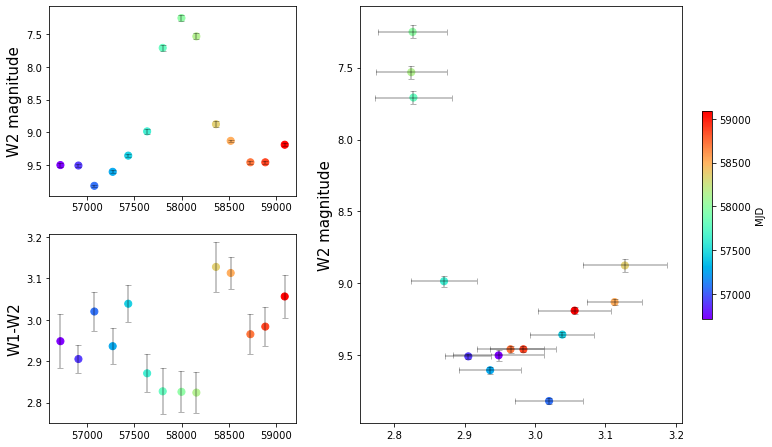

In [16]:
index = 4939   # SSTgbs J0430442+355951


wavg = pa.read_csv('/home/wooseok/WISE_data/3rdnewwise/outlier_cut_data/'+str(index)+'_cavg.csv',
                       header=None, skiprows=1,
                       names=['mjd', 'mag', 'emag', 'flt', 'class'])
    

w2av = wavg[wavg['flt'] == 'W2']
w1av = wavg[wavg['flt'] == 'W1']


col = w1av.mag.values - w2av.mag.values
col_err = np.sqrt(w1av.emag.values**2 + w2av.emag.values**2)


ms = 50
fig = plt.figure(figsize=(11,13))
grid = GridSpec(8,5, #y, x
            left=0.08, bottom=0.06, right=0.98, top=0.99, wspace=0.7, hspace=0.5)

ax0 = fig.add_subplot(grid[0:2, 0:2])
ax1 = fig.add_subplot(grid[2:4, 0:2])
ax2 = fig.add_subplot(grid[0:4, 2:5])


# lightcurve
ax0.errorbar(w2av.mjd,w2av.mag,w2av.emag,fmt='.k',ms=0,capsize=3,alpha=0.3)
ax0.scatter(w2av.mjd,w2av.mag,c=w2av.mjd, s=ms,cmap='rainbow')

ax0.set_ylabel('W2 magnitude',size=15)

ax0.invert_yaxis()


# color
ax1.errorbar(w2av.mjd,col,col_err,fmt='.k',ms=0,capsize=3,alpha=0.3)
ax1c=ax1.scatter(w2av.mjd,col,c=w2av.mjd, s=ms,cmap='rainbow')
ax1.set_ylabel('W1-W2',size=15)



# Color-magnitude diagram
ax2.errorbar(col,w2av.mag,yerr=w2av.emag,xerr=col_err,fmt='.k',ms=0,capsize=3,alpha=0.3)
ax2c=ax2.scatter(col,w2av.mag,c=w2av.mjd, s=ms,cmap='rainbow')
ax2.set_ylabel('W2 magnitude',size=15)
ax2.invert_yaxis()
cbar = fig.colorbar(ax2c, ax=ax2, shrink=0.5, label='MJD')

이후 해야할 작업들 : 
- 논문 순서대로 쭉 정리해볼것. Figure 1 그림부터 시작해서 짜임새있게 그림들 및 방법들을 설명하기.